In [4]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
import matplotlib.pyplot as plt

In [5]:
insurance_train = pd.read_csv("insurance_t.csv")
insurance_validation = pd.read_csv('insurance_v.csv')

In [6]:
categorical_columns = ['MMCRED', 'CCPURC', 'DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS', 'BRANCH']
continuous_columns = [col for col in insurance_train.columns if col not in categorical_columns]

for col in categorical_columns:
    insurance_train[col] = pd.Categorical(insurance_train[col])
    insurance_validation[col] = pd.Categorical(insurance_validation[col])

# Impute missing values
for col in continuous_columns:
    imputer = SimpleImputer(strategy='median')
    insurance_train[col] = imputer.fit_transform(insurance_train[[col]])
    insurance_validation[col] = imputer.transform(insurance_validation[[col]])

for col in ['CC', 'INV', 'CCPURC']:
    imputer = SimpleImputer(strategy='most_frequent')
    insurance_train[col] = imputer.fit_transform(insurance_train[[col]])
    insurance_validation[col] = imputer.transform(insurance_validation[[col]])

# One-hot encode categorical variables
insurance_train_encoded = pd.get_dummies(insurance_train, columns=categorical_columns, drop_first=True)
insurance_validation_encoded = pd.get_dummies(insurance_validation, columns=categorical_columns, drop_first=True)

# Ensure both datasets have the same columns
train_columns = set(insurance_train_encoded.columns)
val_columns = set(insurance_validation_encoded.columns)
missing_cols = train_columns - val_columns
for col in missing_cols:
    insurance_validation_encoded[col] = 0
insurance_validation_encoded = insurance_validation_encoded[insurance_train_encoded.columns]

In [7]:
train_columns == val_columns

False

In [8]:
insurance_train = insurance_train[insurance_train['MMCRED'] != 5]

In [9]:
train_columns = set(insurance_train_encoded.columns)
val_columns = set(insurance_validation_encoded.columns)

In [10]:
# Step 3: Check for duplicate columns 
duplicate_train = insurance_train.columns[insurance_train.columns.duplicated()]
duplicate_val = insurance_validation.columns[insurance_validation.columns.duplicated()]

print("Duplicate columns in training set:", duplicate_train.tolist())
print("Duplicate columns in validation set:", duplicate_val.tolist())

Duplicate columns in training set: []
Duplicate columns in validation set: []


In [11]:
X_train = insurance_train_encoded.drop('INS_1', axis=1)
y_train = insurance_train_encoded['INS_1']
X_val = insurance_validation_encoded.drop('INS_1', axis=1)
y_val = insurance_validation_encoded['INS_1']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



In [12]:
from tensorflow.keras.layers import Input

# Define model with Input layer
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6373 - loss: 0.6589 - val_accuracy: 0.6968 - val_loss: 0.5834
Epoch 2/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6991 - loss: 0.5804 - val_accuracy: 0.7076 - val_loss: 0.5651
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7171 - loss: 0.5632 - val_accuracy: 0.7048 - val_loss: 0.5552
Epoch 4/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7206 - loss: 0.5587 - val_accuracy: 0.7147 - val_loss: 0.5514
Epoch 5/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7250 - loss: 0.5513 - val_accuracy: 0.7166 - val_loss: 0.5479
Epoch 6/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7254 - loss: 0.5422 - val_accuracy: 0.7222 - val_loss: 0.5448
Epoch 7/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7317 - loss: 0.5391 - val_accuracy: 0.7194 - val_loss: 0.5415
Epoch 8/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7394 - loss: 0.5255 - val_accu

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation ROC AUC: 0.7886


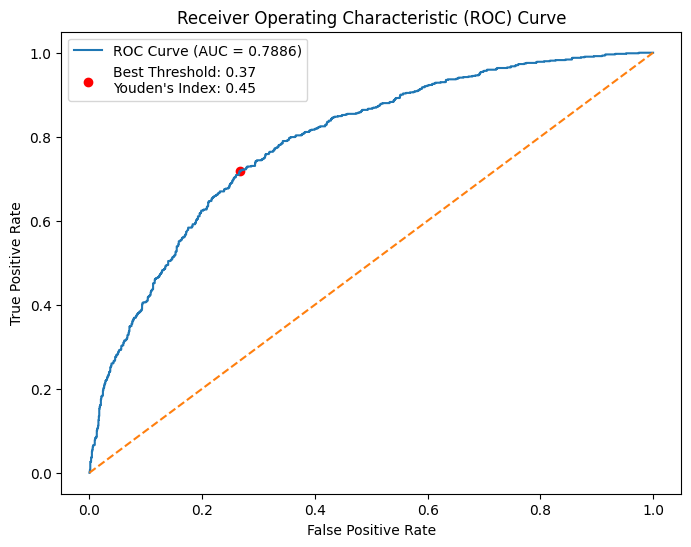

In [13]:
# Calculate ROC AUC and plot ROC curve
y_pred_val_probs = model.predict(X_val_scaled)  # already gives probabilities
val_auc = roc_auc_score(y_val, y_pred_val_probs)

print(f"Validation ROC AUC: {val_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_probs)
# Calculate Youden's Index 
youden_index = tpr - fpr

max_index = youden_index.argmax()

# Get the corresponding TPR, FPR, and threshold
best_threshold = thresholds[max_index]
best_tpr = tpr[max_index]
best_fpr = fpr[max_index]
best_youden_index = youden_index[max_index]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred_val_probs):.4f})')
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold: {best_threshold:.2f}\nYouden\'s Index: {best_youden_index:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



In [24]:
best_tpr = tpr[max_index]
best_fpr = fpr[max_index]
print(best_fpr, best_tpr)

0.2662807525325615 0.7183288409703504


In [26]:
print(best_youden_index)

0.45204808843778893


In [14]:
# Custom scoring function for permutation importance using AUC
def custom_scorer(estimator, X, y):
    y_pred_probs = estimator.predict(X).ravel()
    return roc_auc_score(y, y_pred_probs)

from sklearn.inspection import permutation_importance

# Feature importance
result = permutation_importance(
    estimator=model,
    X=X_val_scaled,
    y=y_val,
    n_repeats=10,
    random_state=42,
    scoring=custom_scorer 
)

feature_importance_df = pd.DataFrame({'feature': X_val.columns, 'importance': result.importances_mean})

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
67/67 ━━━━━━━━━━

In [15]:
print(feature_importance_df.sort_values(by='importance', ascending=False).head(30))


       feature  importance
8       SAVBAL    0.072798
1       DDABAL    0.046394
30       DDA_1    0.020264
9       ATMAMT    0.010323
33       SAV_1    0.010124
7       TELLER    0.009320
36       IRA_1    0.009066
4       CHECKS    0.008383
15       MMBAL    0.008021
12       CDBAL    0.007574
35        CD_1    0.007066
38        MM_1    0.006657
39      CC_1.0    0.006212
48  BRANCH_B16    0.005706
47  BRANCH_B15    0.005601
0      ACCTAGE    0.005352
46  BRANCH_B14    0.004940
34       ATM_1    0.003540
10         POS    0.002333
37     INV_1.0    0.001971
3       DEPAMT    0.001792
2          DEP    0.001617
18       LORES    0.001616
13      IRABAL    0.001505
6        PHONE    0.001419
54   BRANCH_B4    0.001250
32       NSF_1    0.001126
59   BRANCH_B9    0.000994
40       SDB_1    0.000982
41    INAREA_1    0.000894


In [16]:
from alibi.explainers import ALE, plot_ale

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
67/67 ━━━━━━━━━━━━━

<Figure size 1000x600 with 0 Axes>

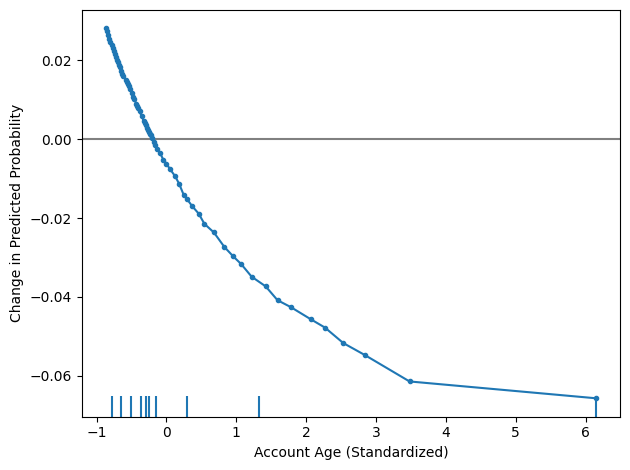

In [18]:
import matplotlib.pyplot as plt

# Generate ALE plot
ale_explainer = ALE(model.predict, feature_names=X_train.columns)
ale_exp_acctage = ale_explainer.explain(X_val_scaled)

# custom size
plt.figure(figsize=(10, 6))

# Plot ALE with customized appearance
plot_ale(ale_exp_acctage, features=['ACCTAGE'])

# Add titles
plt.xlabel("Account Age (Standardized)", fontsize=10)
plt.ylabel("Change in Predicted Probability", fontsize=10)

# Remove legend
plt.gca().get_legend().remove()

# Adjust layout
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

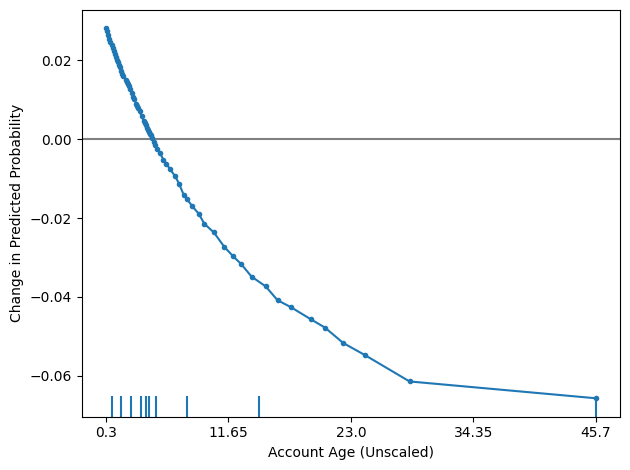

In [21]:
import numpy as np

# Retrieve mean and standard deviation from the StandardScaler instance
mu = scaler.mean_[X_train.columns.get_loc("ACCTAGE")]  # Mean of the 'ACCTAGE' feature
sigma = scaler.scale_[X_train.columns.get_loc("ACCTAGE")]  # Std deviation of the 'ACCTAGE' feature

# Extract the ALE explanation data
x_scaled = ale_exp_acctage.feature_values[0]  # Get the scaled x-axis values

# Unscale the x-axis values
x_original = x_scaled * sigma + mu

# Generate ALE plot
plt.figure(figsize=(10, 6))
plot_ale(ale_exp_acctage, features=['ACCTAGE'])

# Manually update x-axis ticks and labels
tick_positions = np.linspace(min(x_scaled), max(x_scaled), 5)  # Scaled tick positions
tick_labels = np.round(tick_positions * sigma + mu, 2)         # Unscaled values

# Set new tick positions and labels
ax = plt.gca()  # Get current axes
ax.set_xticks(tick_positions)                                 # Update tick positions
ax.set_xticklabels(tick_labels, fontsize=10)                 # Update tick labels with unscaled values

# Add titles and labels
plt.xlabel("Account Age (Unscaled)", fontsize=10)
plt.ylabel("Change in Predicted Probability", fontsize=10)

# Remove legend
plt.gca().get_legend().remove()

# Adjust layout
plt.tight_layout()
plt.show()


In [22]:
insurance_train['ACCTAGE'].value_counts()

ACCTAGE
4.0     698
4.3     305
3.8     286
0.3     267
0.8     188
       ... 
35.9      1
38.1      1
23.4      1
50.4      1
46.6      1
Name: count, Length: 364, dtype: int64